# 2D Wave Propagation Simulation

Waves are all around us, from the sound that we hear to the light that we see. They are nothing more than oscillations that travel through a medium. Wave propagation can be described by a partial differential equation that tells us how the wave amplitude changes over time and space, depending on the medium in which it propagates.

In this notebook, we will focus on simulating the propagation of ultrasound waves in two dimensions using Python and NumPy. We will start by reviewing the general wave equation and its physical interpretation. Then, we will develop a Python implementation of the wave equation and visualize the wave's evolution over time using Matplotlib. Finally, we will explore some variations of the system and simulate them as well.

## The Wave Equation

The wave equation is a fundamental partial differential equation that describes the propagation of waves in a medium. It relates the spatiotemporal evolution of the wave amplitude to its initial conditions and the properties of the medium in which it propagates.

The wave equation can be derived from basic physical principles such as Newton's second law of motion and conservation of energy. It takes the following form:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u
$$

where $u(\mathbf{x},t)$ is the wave amplitude at position $\mathbf{x}=(x,y)$ and time $t$, $\nabla^2$ is the Laplacian operator, and $c$ is the wave speed. The Laplacian operator measures the spatial curvature of the wave amplitude, and the equation states that this curvature is responsible for the propagation of the wave through space and time. 

We can rewrite the equation by replacing the Laplacian operator by it's definition:

$$
\frac{\partial^2 u}{\partial t^2} = c^2\left(\frac{\delta u^2}{\delta^2 x} + \frac{\delta u^2}{\delta^2 y}\right)
$$

This form of the wave equation is more useful for numerical simulations, as it allows us to discretize the spatial derivatives and solve the equation numerically.

### Propagating the Wave

To simulate the propagation of waves, we need to numerically solve the wave equation at each time step. Given the current state of the wave amplitude $u(\mathbf{x},t_n)$ at time $t_n$ (or $t$ for short), we need to find the state of the wave at the next instant of time $t_{n+1}$. We can do this by discretizing the wave equation in space and time and using numerical methods to solve the resulting system of equations.

One commonly used numerical method for solving the wave equation is the finite difference method. This method involves approximating the wave amplitude at each point on a grid using finite differences of neighboring points. By doing this, we can discretize the wave equation and write it as a system of linear equations. We can then solve this system of equations to find the state of the wave at the next time step.

To implement the finite difference method, we need to first discretize the wave equation in space and time. Let $\Delta x$, $\Delta y$, and $\Delta t$ be the grid spacing in space and time. We can approximate the second derivative of the wave amplitude with respect to time and space as:

$$
\frac{\delta^2 u}{\delta t^2} \approx \frac{u(\mathbf{x}, t_{n+1}) - 2u(\mathbf{x}, t_n) + u(\mathbf{x}, t_{n-1})}{\Delta t^2}
$$

$$
\frac{\delta^2 u}{\delta x^2} \approx \frac{u(x_{n+1}, y, t) - 2u(x_n, y, t) + u(x_{n-1}, y, t)}{\Delta x^2}
$$

$$
\frac{\delta^2 u}{\delta y^2} \approx \frac{u(x, y_{n+1}, t) - 2u(x, y_n, t) + u(x, y_{n-1}, t)}{\Delta y^2}
$$

Plugging these into the wave equation leaves us with:

$$
\frac{1}{c^2} \frac{u(x, y, t_{n+1}) - 2u(x, y, t_n) + u(x, y, t_{n-1})}{\Delta t^2} \approx \frac{u(x_{n+1}, y, t) - 2u(x, y, t) + u(x_{n-1}, y, t)}{\Delta x^2} + \frac{u(x, y_{n+1}, t) - 2u(x, y, t) + u(x, y_{n-1}, t)}{\Delta y^2}
$$ 

To properly simulate the wave propagation, we must be able to calculate the state of the wave at the next time step $u(\mathbf{x}, t_{n+1})$. We can isolate this term from the equation above to find the update equation. For the purposes of this document, we will only consider discrete time and space, which let's us simplify the deltas:

$$
u(x, y, t_{n+1}) \approx [u(x_{n+1}, y) + u(x_{n-1}, y) +  u(x, y_{n+1}) + u(x, y_{n-1}) - 4 u(x, y)]c^2 + 2u(x, y, t_n) - 2u(x, y, t_{n-1})
$$

Note that, for simplicitly, the time $t$ is implicit on some of these terms.

## The Simulation

Now that we have a better understanding of the mathematical concepts behind the wave propagation simulation, we can move on to implementing it in code using Python and NumPy. We start off by importing the required modules and preparing the environment.

In [1]:
%matplotlib inline

In [2]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

First things first, we need to define the parameters of our simulation. We will use a squared grid of size $N$, the simulation will contemplate $T$ moments of time and our velocity constant is set to $c$. 

In [3]:
N = 120
T = 1000
c = 0.3

We can now create our initial grid, which will be filled with zeros. We also define the array that represents the time dimension of our simulation. For now, we skip the time steps 0 and 1 as we will be using it to set the initial simulation state. To calculate the next step, we must know the previous two steps as we've seen above. We also skip the last time step as calculating the wave at $t=T+1$ would need data that is out of the scope of the simulation.

In [4]:
G = np.zeros((T, N, N))
t = np.arange(2, T-1)

For our initial state, we sample random coordinates and set an arbitrary initial wave amplitude in our zeroed grid.

In [5]:
i, j = tuple(np.random.randint(N, size=2))
G[:2, i, j] = 1

We are now ready to implement the update equation, so we will start by the laplassian. For that, we must decide how to deal with the simulation bounds, as our ROI (Region of Interest) is a square matrix $N\times N$, and the computation must eventually stop as we reach the borders. There are mainly two approaches we can take about the simulation bounds: we can either pad our grid with zeroes that would zero out out of bound values, or simply leave the values at the edges out of our loop.

After that, we need to take into account the $t$ and $t_{n-1}$ instants of time to calculate the propagation at $t_{n+1}$. A simplistic approach to the numeric computation of the wave equation is presented below.

```python
def laplassian(G, t):
    return (G[t, x+1, y] + G[t, x-1, y] + G[t, x, y+1] + G[t, x, y-1]) - 4 * G[t, x, y]

for i in t:
    for x in range(N-1):
        for y in range(N-1):
            G[i+1, x, y] = laplassian(G, i) * np.power(c, 2) + 2 * G[i, x, y] - G[i-1, x, y]
```

Alternatively, we can pad our matrix with zeroes and perform a vectorized operation that calculates the propagation at a given moment of time $t$ all at once for better performance:

In [6]:
def laplassian(G):
    G_pad =  np.pad(G, (1,))
    return (G_pad[1:-1, 2:] + G_pad[1:-1, :-2] + G_pad[2:, 1:-1] + G_pad[:-2, 1:-1]) - 4 * G

In [7]:
for i in t:
    G[i+1] = laplassian(G[i]) * np.power(c, 2) + 2 * G[i] - G[i-1] 

We define some helper functions to make it easier to visualize the propagation of the initial impulse:

In [8]:
def animate_propagation(G):
    def animate(t):
        im.set_array(G[t])
        return im,
        
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')

    im = plt.imshow(G[-1, :, :])
    animation = FuncAnimation(fig, animate, frames=G.shape[0], interval=10, repeat=True)
    plt.colorbar()
    plt.close()
    
    return HTML(animation.to_html5_video())

Finally, the simulation results:

In [9]:
animate_propagation(G)

All of this aliasing we see can be explained by the Nyquist stability criterion as we are using a impulse signal.

## Adding Sources

The previous simulation did not start from rest: the initial state included an impulse disturbance that was responsible for the propagation that followed. We also have the option to obtain similar results simulating from rest as long as we have a source of disturbance. We will use a sinusoidal signal for that.

In [10]:
def sinusoidal_source(freq, t):
    return np.cos(freq * 2 * np.pi * t)

We can verify that it behaves as expected:

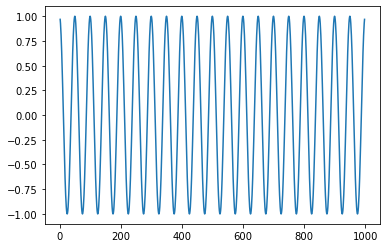

In [11]:
# frequency is specified as units of cycles per unit time. this gives us 50 cycles for any given t
freq = 1/50 
sinusoidal = sinusoidal_source(freq, t) 
plt.plot(t, sinusoidal);

We can now replicate our simulation, but instead of disturbing our initial state, we can add our source at a random point of the grid. Of course, we also need to include it as part of the wave equation formulation:

$$
u(x, y, t_{n+1}) \approx [u(x_{n+1}, y) + u(x_{n-1}, y) +  u(x, y_{n+1}) + u(x, y_{n-1}) - 4 u(x, y)]c^2 + 2u(x, y, t_n) - 2u(x, y, t_{n-1}) + s(x, y, t)
$$

In [12]:
# initial state
G = np.zeros((T, N, N))
t = np.arange(T)
s = np.zeros_like(G)

In [13]:
# random source of disturbance
i, j = tuple(np.random.randint(N, size=2))
s[:, i, j] = sinusoidal_source(freq, t)

In [14]:
# update equation
for i in t[:-1]:
    G[i+1] = laplassian(G[i]) * np.power(c, 2) + 2 * G[i] - G[i-1] + s[i]

In [15]:
animate_propagation(G)

Works as expected, but things get a bit caotic later on since the source keeps emitting waves. We could use a single gaussian pulse instead to excite the resting system. We will use a normal distribution to envelop our sinusoidal source. We can take a look at how both signals look like separately:

In [16]:
def gaussian_source(mu, sigma):
    return np.exp(-0.5 * ((t - mu)**2 / sigma**2) / (sigma * np.sqrt(2 * np.pi)))

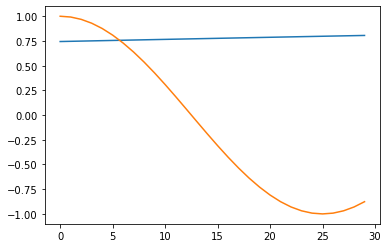

In [49]:
gaussian = gaussian_source(4 / freq, 1 * len(t) )
sinusoidal = sinusoidal_source(freq, t) 
plt.plot(t, gaussian)
plt.plot(t, sinusoidal);

In [46]:
def gaussian_source2(t, mu, sigma):
    return np.exp(-0.5 * ((t - mu)**2 / sigma**2) / (sigma * np.sqrt(2 * np.pi)))
print(len(t)/150)
t = np.arange(30)
gaussian_source2(t, 4/freq, 0.1 * len(t))

0.2


array([4.57532026e-129, 8.72185364e-128, 1.63824598e-126, 3.03202270e-125,
       5.52928286e-124, 9.93546477e-123, 1.75910024e-121, 3.06885247e-120,
       5.27526710e-119, 8.93502800e-118, 1.49118114e-116, 2.45215495e-115,
       3.97327328e-114, 6.34354442e-113, 9.97926498e-112, 1.54684980e-110,
       2.36254863e-109, 3.55546485e-108, 5.27223844e-107, 7.70329835e-106,
       1.10902520e-104, 1.57321881e-103, 2.19897286e-102, 3.02854219e-101,
       4.10989199e-100, 5.49553794e-099, 7.24057460e-098, 9.39980569e-097,
       1.20239660e-095, 1.51551286e-094])

What we are looking for is their product, which looks like this

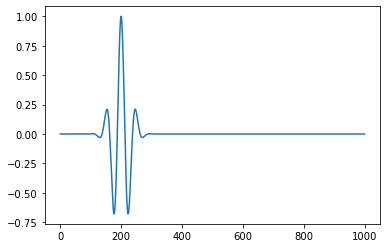

In [18]:
plt.plot(t, gaussian * sinusoidal);

The rest of the simulation is exactly the same

In [19]:
G = np.zeros((T, N, N))
t = np.arange(T)
s = np.zeros_like(G)

In [20]:
i, j = tuple(np.random.randint(N, size=2))
s[:, i, j] = gaussian * sinusoidal

In [21]:
for i in t[:-1]:
    G[i+1] = laplassian(G[i]) * np.power(c, 2) + 2 * G[i] - G[i-1] + s[i]

In [22]:
animate_propagation(G)

## Defining Obstacles

We can see that the waves reflect off of the simulation border. This happens because the speed outside our ROI is essentially 0, and this difference in propagation speed results in the reflection we've been observing. But what about obstacles inside our ROI? We could transform our scalar constant $c$ into a matrix of velocities $C$ where the the velocity at a given point is an arbitraty value $C(x, y)$.

Let's see how the simulation behaves if we define a square shaped region in the middle of our ROI with just 20% of the propagation speed $c$.

In [23]:
G = np.zeros((T, N, N))
t = np.arange(T)
s = np.zeros_like(G)

In [24]:
i, j = tuple(np.random.randint(N, size=2))
s[:, i, j] = gaussian * sinusoidal

Now for our propagation speed matrix:

In [25]:
C = np.full((N, N), c)
half = int(N/2)
offset = 10
lower_bound, upper_bound = half-offset, half+offset
C[lower_bound:upper_bound, lower_bound:upper_bound] = c / 5

In [26]:
for i in t[:-1]:
    G[i+1] = laplassian(G[i]) * np.power(C, 2) + 2 * G[i] - G[i-1] + s[i]

In [27]:
animate_propagation(G)

We can see that the waves now reflect off of the center of our grid. Since the propagation speed in this region is not zero, some of the waves actually gets through it, albeit in a much slower fashion.